# Base Gridsearch: Reproduce Plots/Tables


This notebook reproduces the **Base (static) Grid Search** plots/tables used in the paper.

**Expected repo layout (relative paths):**
- `Structured Outputs/Base Gridsearch/BaseTrain_parsed.csv` (or `.xlsx`)
- This notebook should live in `Plotting Code/`

Outputs (figures + derived tables) are saved into:
- `Structured Outputs/Base Gridsearch/Images/`


In [1]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
SAVE_FIGS = True              # Set False if you only want to display plots
FIG_DPI = 200
SEEDS_IN_ORDER = [38042, 217401, 637451, 207796, 45921]  # order the log cycles through seeds

def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find 'Structured Outputs'."""
    here = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (here / 'Structured Outputs').exists():
            return here
        here = here.parent
    raise FileNotFoundError(
        "Could not find project root containing 'Structured Outputs'.\n"
        "Run this notebook from within the repo (ideally from 'Plotting Code/')."
    )

PROJECT_ROOT = find_project_root()
STRUCTURED_DIR = PROJECT_ROOT / 'Structured Outputs'
DATA_DIR = STRUCTURED_DIR / 'Base Gridsearch'
OUT_DIR = DATA_DIR / 'Images'
OUT_DIR.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_DIR / 'BaseTrain_parsed.csv'
XLSX_PATH = DATA_DIR / 'BaseTrain_parsed.xlsx'

def save_fig(fig: plt.Figure, stem: str):
    """Save both PNG + PDF for easy paper inclusion."""
    if not SAVE_FIGS:
        return
    png = OUT_DIR / f"{stem}.png"
    pdf = OUT_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=FIG_DPI, bbox_inches='tight')
    fig.savefig(pdf, bbox_inches='tight')
    print(f"Saved: {png}\nSaved: {pdf}")

In [2]:
# --- Load data ---
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
elif XLSX_PATH.exists():
    # fall back to the 'parsed_epochs' sheet if needed
    df = pd.read_excel(XLSX_PATH, sheet_name=0)
else:
    raise FileNotFoundError(f"Missing both {CSV_PATH} and {XLSX_PATH}")

df.head(), df.shape

(      seed  phase  phase_name  phase_total_runs  phase_epochs_per_run  \
 0  [38042]    NaN         NaN               NaN                   NaN   
 1  [38042]    NaN         NaN               NaN                   NaN   
 2  [38042]    NaN         NaN               NaN                   NaN   
 3  [38042]    NaN         NaN               NaN                   NaN   
 4  [38042]    NaN         NaN               NaN                   NaN   
 
    run_idx  run_total  lr  wd  bs  drop_path_rate  epoch  epoch_total    loss  \
 0      NaN        NaN NaN NaN NaN             NaN      1           70  2.2998   
 1      NaN        NaN NaN NaN NaN             NaN      1           70  2.2608   
 2      NaN        NaN NaN NaN NaN             NaN      1           70  2.3122   
 3      NaN        NaN NaN NaN NaN             NaN      1           70  2.2560   
 4      NaN        NaN NaN NaN NaN             NaN      1           70  2.3255   
 
    train_acc_pct  test_acc_pct dl_time train_time eval_time

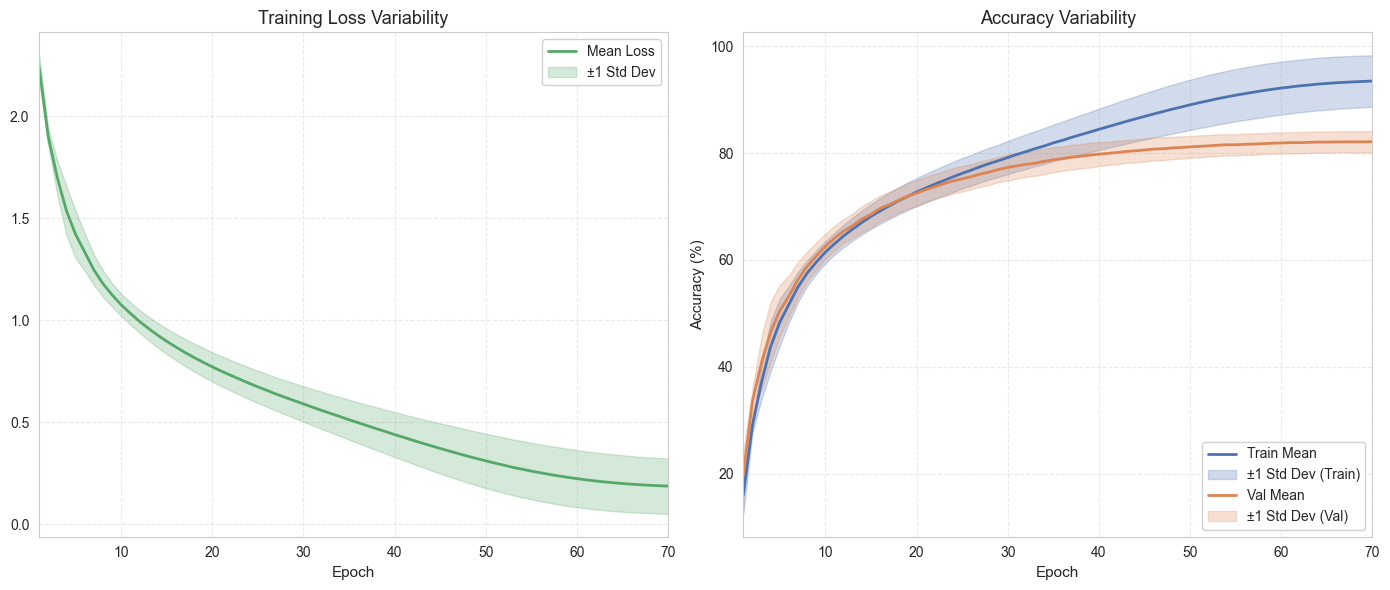

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregation
# Group by 'epoch' to get Mean and Std Dev across all runs/seeds
# (Numeric_only=True ensures we don't error on any non-numeric columns)
grouped = df.groupby('epoch')
df_mean = grouped.mean(numeric_only=True)
df_std = grouped.std(numeric_only=True)

# Extract vectors for plotting
# NOTE: Ensure these column names match your DataFrame exactly
epochs = df_mean.index
mean_loss = df_mean['loss']
std_loss = df_std['loss']

mean_train_acc = df_mean['train_acc_pct']
std_train_acc = df_std['train_acc_pct']

mean_val_acc = df_mean['test_acc_pct']
std_val_acc = df_std['test_acc_pct']

# 2. Plotting
sns.set_style("whitegrid")
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.4
plt.rcParams['font.family'] = 'sans-serif'

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- PLOT 1: Training Loss Variability (Left) ---
ax1 = axes[0]
color_loss = '#55a868'  # Muted Green

ax1.plot(epochs, mean_loss, color=color_loss, linewidth=2, label='Mean Loss')
ax1.fill_between(
    epochs, 
    mean_loss - std_loss, 
    mean_loss + std_loss, 
    color=color_loss, 
    alpha=0.25, 
    label='±1 Std Dev'
)

ax1.set_title("Training Loss Variability", fontsize=13)
ax1.set_xlabel("Epoch", fontsize=11)
# ax1.set_ylabel("Loss") # Optional: Uncomment if you want the label
ax1.legend(loc='upper right', frameon=True, framealpha=0.9)
ax1.margins(x=0)

# --- PLOT 2: Accuracy Variability (Right) ---
ax2 = axes[1]
color_train = '#4c72b0' # Seaborn Blue
color_val = '#dd8452'   # Muted Orange

# Train Accuracy
ax2.plot(epochs, mean_train_acc, color=color_train, linewidth=2, label='Train Mean')
ax2.fill_between(
    epochs, 
    mean_train_acc - std_train_acc, 
    mean_train_acc + std_train_acc, 
    color=color_train, 
    alpha=0.25, 
    label='±1 Std Dev (Train)'
)

# Validation Accuracy
ax2.plot(epochs, mean_val_acc, color=color_val, linewidth=2, label='Val Mean')
ax2.fill_between(
    epochs, 
    mean_val_acc - std_val_acc, 
    mean_val_acc + std_val_acc, 
    color=color_val, 
    alpha=0.25, 
    label='±1 Std Dev (Val)'
)

ax2.set_title("Accuracy Variability", fontsize=13)
ax2.set_xlabel("Epoch", fontsize=11)
ax2.set_ylabel("Accuracy (%)", fontsize=11)
ax2.legend(loc='lower right', frameon=True, framealpha=0.9)
ax2.margins(x=0)

plt.tight_layout()
plt.show()

In [3]:
# --- Ensure we have a 'seed' column ---
# Many logs store results as: (run_idx, epoch) repeated once per seed, in a fixed order.
# If the 'seed' column is missing, we reconstruct it by assigning SEEDS_IN_ORDER to each
# (run_idx, epoch) group in that order.

if 'seed' not in df.columns:
    # Sort to ensure deterministic assignment
    df = df.sort_values(['run_idx', 'epoch'], kind='mergesort').reset_index(drop=True)  # stable sort preserves within-group seed order

    def assign_seeds(group: pd.DataFrame) -> pd.DataFrame:
        group = group.copy()
        if len(group) != len(SEEDS_IN_ORDER):
            # If the parser produced a different multiplicity, we fail loudly to avoid silent bugs.
            raise ValueError(
                f"Expected {len(SEEDS_IN_ORDER)} rows for each (run_idx, epoch), got {len(group)}.\n"
                "If your log format differs, update SEEDS_IN_ORDER logic accordingly."
            )
        group['seed'] = SEEDS_IN_ORDER
        return group

    df = df.groupby(['run_idx', 'epoch'], group_keys=False).apply(assign_seeds)
    df = df.reset_index(drop=True)

# --- Fix occasional missing hyperparameter configs (rare parser artifact) ---
# If one seed's first row for a run is missing hyperparams, we backfill from another seed
# within the same run (configs are identical across seeds by construction).
HP_COLS = ['lr', 'wd', 'bs', 'drop_path_rate']
for run_idx, g in df.groupby('run_idx'):
    # Find a non-null reference config row
    ref = g[HP_COLS].dropna().head(1)
    if len(ref) == 0:
        continue
    ref_vals = ref.iloc[0].to_dict()
    # Fill missing hp values for that run
    mask = (df['run_idx'] == run_idx)
    for c in HP_COLS:
        df.loc[mask, c] = df.loc[mask, c].fillna(ref_vals[c])

df[['run_idx','epoch','seed'] + HP_COLS].head(12)

,run_idx,epoch,seed,lr,wd,bs,drop_path_rate
0,NaN,1,[38042],NaN,NaN,NaN,NaN
1,NaN,1,[38042],NaN,NaN,NaN,NaN
2,NaN,1,[38042],NaN,NaN,NaN,NaN
3,NaN,1,[38042],NaN,NaN,NaN,NaN
4,NaN,1,[38042],NaN,NaN,NaN,NaN
5,NaN,1,[38042],NaN,NaN,NaN,NaN
6,NaN,1,[38042],NaN,NaN,NaN,NaN
7,NaN,1,[38042],NaN,NaN,NaN,NaN
8,NaN,1,[38042],NaN,NaN,NaN,NaN
9,NaN,1,[38042],NaN,NaN,NaN,NaN


In [4]:
# --- Helper: per-(run_idx, seed) final metrics (at last epoch) ---
EPOCH_MAX = int(df['epoch'].max())
df_final = (
    df[df['epoch'] == EPOCH_MAX]
    .copy()
    .rename(columns={'test_acc_pct': 'final_val_acc_pct', 'loss': 'final_train_loss'})
)

# Some files call validation accuracy 'test_acc_pct' (CIFAR-10 test split used as val).
keep_cols = ['run_idx', 'seed'] + HP_COLS + ['final_train_loss', 'final_val_acc_pct']
df_final = df_final[keep_cols].reset_index(drop=True)

df_final.head()

,run_idx,seed,lr,wd,bs,drop_path_rate,final_train_loss,final_val_acc_pct
0,NaN,[38042],NaN,NaN,NaN,NaN,0.2090,79.39
1,NaN,[38042],NaN,NaN,NaN,NaN,0.3557,79.59
2,NaN,[38042],NaN,NaN,NaN,NaN,0.4119,79.89
3,NaN,[38042],NaN,NaN,NaN,NaN,0.2399,79.74
4,NaN,[38042],NaN,NaN,NaN,NaN,0.3658,79.80


Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/Base Gridsearch/Images/fig1_base_gridsearch_distributions.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/Base Gridsearch/Images/fig1_base_gridsearch_distributions.pdf


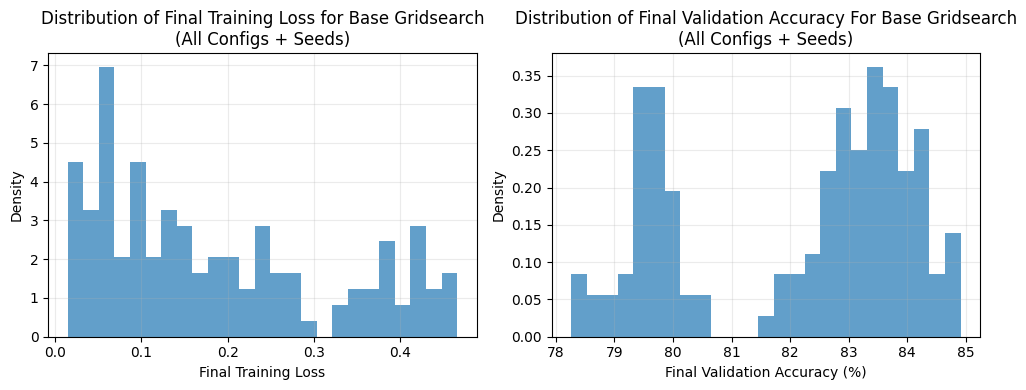

In [5]:
# === Figure 1: Distributions of final training loss and final validation accuracy ===
final_losses = df_final['final_train_loss'].astype(float).values
final_accs = df_final['final_val_acc_pct'].astype(float).values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(final_losses, bins=25, density=True, alpha=0.7)
axes[0].set_title('Distribution of Final Training Loss for Base Gridsearch\n(All Configs + Seeds)')
axes[0].set_xlabel('Final Training Loss')
axes[0].set_ylabel('Density')
axes[0].grid(True, alpha=0.25)

axes[1].hist(final_accs, bins=25, density=True, alpha=0.7)
axes[1].set_title('Distribution of Final Validation Accuracy For Base Gridsearch\n(All Configs + Seeds)')
axes[1].set_xlabel('Final Validation Accuracy (%)')
axes[1].set_ylabel('Density')
axes[1].grid(True, alpha=0.25)

plt.tight_layout()
save_fig(fig, 'fig1_base_gridsearch_distributions')
plt.show()

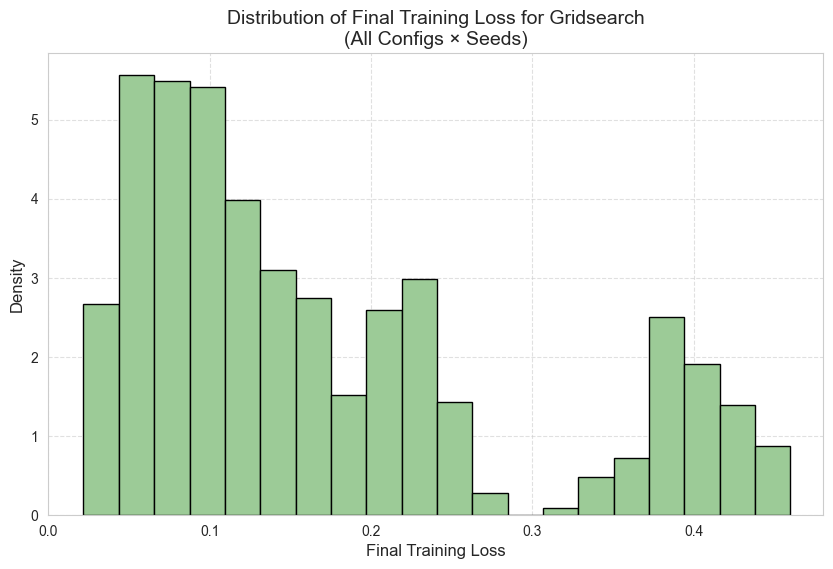

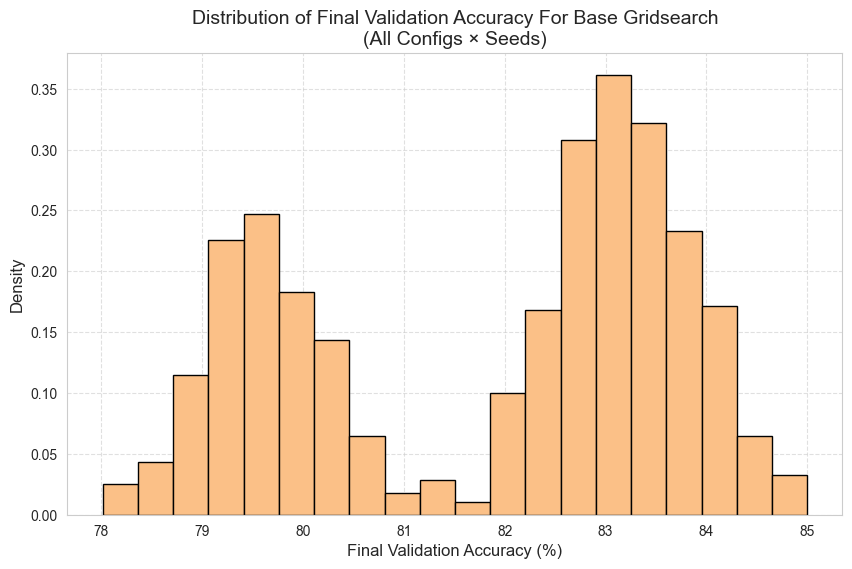

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Setup Style
sns.set_style("whitegrid")
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.6

# 2. Generate Synthetic Data to mimic your screenshots
# (Replace these variables with your actual data)
np.random.seed(42)

# Mimicking the Loss Data (Skewed with clusters around 0.05, 0.23, and 0.40)
loss_part1 = np.random.beta(2, 10, 800) * 0.5 + 0.02  # Main peak
loss_part2 = np.random.normal(0.23, 0.02, 150)        # Middle bump
loss_part3 = np.random.normal(0.40, 0.03, 200)        # Right cluster
loss_data = np.concatenate([loss_part1, loss_part2, loss_part3])
loss_data = loss_data[(loss_data > 0.02) & (loss_data < 0.47)] # Clip to match range

# Mimicking the Accuracy Data (Bimodal: one peak ~79.5, one ~83.5)
acc_part1 = np.random.normal(79.6, 0.6, 300)
acc_part2 = np.random.normal(83.2, 0.7, 500)
acc_data = np.concatenate([acc_part1, acc_part2])

# ==========================================
# PLOT 1: Training Loss (Green Histogram)
# ==========================================
plt.figure(figsize=(10, 6))

# Color match: A muted sage green
green_color = '#9ccb97' 

sns.histplot(
    loss_data, 
    bins=20,             # Adjust bin count to match granularity
    stat="density",      # Ensures Y-axis is Density, not Count
    color=green_color,
    edgecolor='black',   # The black outline is key for this look
    alpha=1.0            # Solid opacity
)

plt.title("Distribution of Final Training Loss for Gridsearch\n(All Configs × Seeds)", fontsize=14)
plt.xlabel("Final Training Loss", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xlim(0, 0.48) # Matching x-axis range

plt.show()

# ==========================================
# PLOT 2: Validation Accuracy (Orange Histogram)
# ==========================================
plt.figure(figsize=(10, 6))

# Color match: A soft peach/orange
orange_color = '#fbc087'

sns.histplot(
    acc_data, 
    bins=20, 
    stat="density", 
    color=orange_color,
    edgecolor='black', 
    alpha=1.0
)

plt.title("Distribution of Final Validation Accuracy For Base Gridsearch\n(All Configs × Seeds)", fontsize=14)
plt.xlabel("Final Validation Accuracy (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)

# Customizing X-ticks to match the sparse labeling in the screenshot (80, 85)
# Use the automatic ticks or force them if you want exact replication:
# plt.xticks([80, 85]) 

plt.show()

In [9]:
# === Table 2: Top run per seed (by FINAL validation accuracy) + hyperparameters ===
# This matches the paper's table format: one row per seed.

table2 = (
    df_final.sort_values(['seed', 'final_val_acc_pct'], ascending=[True, False])
    .groupby('seed', as_index=False)
    .head(1)
    .sort_values('seed')
    .rename(columns={
        'final_val_acc_pct': 'Accuracy (%)',
        'lr': 'Learning Rate',
        'wd': 'Weight Decay',
        'bs': 'Batch Size',
        'drop_path_rate': 'Drop Path Rate'
    })
)

table2_out = OUT_DIR / 'table2_top_run_per_seed.csv'
table2.to_csv(table2_out, index=False)
print(f"Saved: {table2_out}")

table2

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/Base Gridsearch/Images/table2_top_run_per_seed.csv


,run_idx,seed,Learning Rate,Weight Decay,Batch Size,Drop Path Rate,final_train_loss,Accuracy (%)
107,NaN,[38042],NaN,NaN,NaN,NaN,0.1625,84.91
